# Heartbeat Classification - Data Exploration

## Project Overview
Exploratory data analysis on ECG heartbet classification dataset from Kaggle competition.

**Datasets:**
- MIT-BIH Arrhythmia Dataset (5 classes)
- PTB Diagnostic ECG Database (2 classes: normal/abnormal)

**Objective:** Understand data structure, identify patterns, and prepare for preprocessing. Create 5 High-Quality graphs.



In [1]:
# Core libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Statistical analysis
from scipy.stats import kruskal, chisquare, kstest

# Data handling
import warnings
warnings.filterwarnings('ignore')

# System libraries
import sys
# Add the project root directory to Python path
sys.path.append('..')

# Set random seed for reproducibility
np.random.seed(42)

# Custom utils
from src.data.audit_report import generate_data_audit_report, generate_summary_report
from src.visualization.visualization import plot_heartbeat, plot_multiple_heartbeats

## 1. DataSet Descriptions

### PTBDB_*.csv

- derived from PTB Diagnostic ECG Database
- designed for classifying electrocardiogram ECG signals into normal and abnormal heartbeats

### MITBIH_*.csv

- derived form Physionet's MIT-BIH Arrhytmia Dataset
- designed for classifying ECG signals into 5 categories (N, S, V, F, Q)
- each column represents a time point in a 10-second ECG signal, sampled at 125Hz. Values normalized between 0 and 1.

### What they have in common

- each column represents a time point in a 10-second ECG signal, sampled at 125HZ. Values normalized between 0 and 1.
- padded with zeros if necessary to the fixed dimension of 188
- Column 188 = class label (target), while dataset is already splitted according to the label.

## 2. Data Loading & Structure

In [2]:
ptbdb_normal = pd.read_csv("../data/original/ptbdb_normal.csv", header=None)
display(ptbdb_normal.head())

print("Dataset shapes:", ptbdb_normal.shape, ptbdb_normal.shape)
print("Data types:", ptbdb_normal.dtypes.value_counts())
print("Memory usage:", ptbdb_normal.memory_usage(deep=True).sum() / 1024**2, "MB")
print("Duplicates - deleted! ", ptbdb_normal.duplicated().sum())
print(ptbdb_normal[187].value_counts())

ptbdb_normal.drop_duplicates(inplace=True)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.900324,0.358590,0.051459,0.046596,0.126823,0.133306,0.119125,0.110616,0.113047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,0.794681,0.375387,0.116883,0.000000,0.171923,0.283859,0.293754,0.325912,0.345083,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.909029,0.791482,0.423169,0.186712,0.000000,0.007836,0.063032,0.077002,0.074957,0.077342,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.478893,0.056760,0.064176,0.081289,0.072732,0.055619,0.048774,0.054478,0.041643,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.000000,0.867238,0.201360,0.099349,0.141336,0.120934,0.108516,0.096393,0.093436,0.100828,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dataset shapes: (4046, 188) (4046, 188)
Data types: float64    188
Name: count, dtype: int64
Memory usage: 5.803409576416016 MB
Duplicates - deleted!  1
187
0.0    4046
Name: count, dtype: int64


In [3]:
ptbdb_abnormal = pd.read_csv("../data/original/ptbdb_abnormal.csv", header=None)
display(ptbdb_abnormal.head())

print("Dataset shapes:", ptbdb_abnormal.shape, ptbdb_abnormal.shape)
print("Data types:", ptbdb_abnormal.dtypes.value_counts())
print("Memory usage:", ptbdb_abnormal.memory_usage(deep=True).sum() / 1024**2, "MB")
print("Duplicates - deleted! ", ptbdb_abnormal.duplicated().sum())

print(ptbdb_abnormal[187].value_counts())

ptbdb_abnormal.drop_duplicates(inplace=True)

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.932233,0.869679,0.886186,0.929626,0.908775,0.933970,0.801043,0.749783,0.687229,0.635100,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,1.000000,0.606941,0.384181,0.254237,0.223567,0.276836,0.253430,0.184826,0.153349,0.121872,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,1.000000,0.951613,0.923963,0.853303,0.791859,0.734255,0.672043,0.685100,0.670507,0.667435,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.977819,0.899261,0.230129,0.032348,0.142329,0.223660,0.328096,0.367837,0.381701,0.389094,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.935618,0.801661,0.805815,1.000000,0.722741,0.480789,0.454829,0.319834,0.266874,0.308411,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


Dataset shapes: (10506, 188) (10506, 188)
Data types: float64    188
Name: count, dtype: int64
Memory usage: 15.069156646728516 MB
Duplicates - deleted!  6
187
1.0    10506
Name: count, dtype: int64


In [4]:
mitbih_test = pd.read_csv("../data/original/mitbih_test.csv", header=None)
display(mitbih_test.head())

print("Dataset shapes:", mitbih_test.shape, mitbih_test.shape)
print("Data types:", mitbih_test.dtypes.value_counts())
print("Memory usage:", mitbih_test.memory_usage(deep=True).sum() / 1024**2, "MB")
print("Duplicates - 0! ", mitbih_test.duplicated().sum())

print(mitbih_test[187].value_counts())



,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,1.000000,0.758264,0.111570,0.000000,0.080579,0.078512,0.066116,0.049587,0.047521,0.035124,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.908425,0.783883,0.531136,0.362637,0.366300,0.344322,0.333333,0.307692,0.296703,0.300366,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.730088,0.212389,0.000000,0.119469,0.101770,0.101770,0.110619,0.123894,0.115044,0.132743,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.000000,0.910417,0.681250,0.472917,0.229167,0.068750,0.000000,0.004167,0.014583,0.054167,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.570470,0.399329,0.238255,0.147651,0.000000,0.003356,0.040268,0.080537,0.070470,0.090604,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dataset shapes: (21892, 188) (21892, 188)
Data types: float64    188
Name: count, dtype: int64
Memory usage: 31.400394439697266 MB
Duplicates - 0!  0
187
0.0    18118
4.0     1608
2.0     1448
1.0      556
3.0      162
Name: count, dtype: int64


In [5]:
mitbih_train = pd.read_csv("../data/original/mitbih_train.csv", header=None)
display(mitbih_train.head())

print("Dataset shapes:", mitbih_train.shape, mitbih_train.shape)
print("Data types:", mitbih_train.dtypes.value_counts())
print("Memory usage:", mitbih_train.memory_usage(deep=True).sum() / 1024**2, "MB")
print("Duplicates - 0! ", mitbih_train.duplicated().sum())

print(mitbih_train[187].value_counts())

,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
0,0.977941,0.926471,0.681373,0.245098,0.154412,0.191176,0.151961,0.085784,0.058824,0.049020,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.960114,0.863248,0.461538,0.196581,0.094017,0.125356,0.099715,0.088319,0.074074,0.082621,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.000000,0.659459,0.186486,0.070270,0.070270,0.059459,0.056757,0.043243,0.054054,0.045946,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.925414,0.665746,0.541436,0.276243,0.196133,0.077348,0.071823,0.060773,0.066298,0.058011,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.967136,1.000000,0.830986,0.586854,0.356808,0.248826,0.145540,0.089202,0.117371,0.150235,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dataset shapes: (87554, 188) (87554, 188)
Data types: float64    188
Name: count, dtype: int64
Memory usage: 125.58111953735352 MB
Duplicates - 0!  0
187
0.0    72471
4.0     6431
2.0     5788
1.0     2223
3.0      641
Name: count, dtype: int64


In [6]:
# mitbih labels mapping
mitbih_labels_map = {0: 'N', 1: 'S', 2: 'V', 3: 'F', 4: 'Q'}
mitbih_labels_to_desc = {"N": "Normal", "S": "Supraventricular premature beat", "V": "Premature ventricular contraction", "F": "Fusion of V+N", "Q": "Unclassified"}

## 3. Dataset consistency

In [7]:
# Missing values analysis
datasets = [mitbih_train, mitbih_test, ptbdb_normal, ptbdb_abnormal]
for i, dataset in enumerate(datasets):
    total_missing = dataset.isnull().sum().sum()
    missing_per_column = dataset.isnull().sum()
    missing_percentage = (dataset.isnull().sum() / len(dataset)) * 100
    print(f"Dataset {i+1} - Total missing values: {total_missing}")
    # print(f"Dataset {i+1} - Missing values per column:\n{missing_per_column}")
    # print(f"Dataset {i+1} - Missing values percentage per column:\n{missing_percentage}\n")

    # Data range analysis
    # print("Signal amplitude range:", dataset.describe())

Dataset 1 - Total missing values: 0
Dataset 2 - Total missing values: 0
Dataset 3 - Total missing values: 0
Dataset 4 - Total missing values: 0


*NO MISSING VALUES!*

In [8]:
ptbdb = pd.concat([ptbdb_abnormal, ptbdb_normal], axis=0).reset_index(drop=True)
mitbih = pd.concat([mitbih_train, mitbih_test], axis=0).reset_index(drop=True)
for i, dataset in enumerate([ptbdb, mitbih ]):
    if i == 0:
        name = "ptbdb"
    else:
        name = "mitbih"
    print(f"Dataset {name} - Shape: {dataset.shape}")
    zero_mean_columns = dataset.columns[dataset.describe().loc['mean'] == 0].tolist()
    print(f"Dataset {name} - Columns (columnname(s)) with zero mean: {zero_mean_columns}")
    display(dataset.describe())



Dataset ptbdb - Shape: (14545, 188)
Dataset ptbdb - Columns (columnname(s)) with zero mean: [186]


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,...,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.000000,14545.0,14545.000000
mean,0.976653,0.721557,0.402995,0.242797,0.207125,0.216400,0.221714,0.224460,0.227329,0.229686,...,0.001190,0.001134,0.000900,0.000740,0.000661,0.000475,0.000177,0.000185,0.0,0.721898
std,0.034492,0.195670,0.249764,0.249458,0.218014,0.192371,0.180723,0.176934,0.176668,0.176574,...,0.021366,0.021017,0.017320,0.014644,0.014036,0.012292,0.006546,0.006837,0.0,0.448080
min,0.624227,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
25%,0.959384,0.584416,0.212267,0.052265,0.061875,0.090494,0.096449,0.097091,0.097222,0.097118,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,1.000000,0.740092,0.371809,0.168016,0.136059,0.159399,0.167457,0.171482,0.177340,0.180328,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
75%,1.000000,0.881134,0.557580,0.335885,0.264039,0.264544,0.286377,0.302251,0.311659,0.325280,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.985523,0.993213,0.997738,...,0.791899,0.773743,0.789804,0.628177,0.602033,0.644880,0.371502,0.376668,0.0,1.000000


Dataset mitbih - Shape: (109446, 188)
Dataset mitbih - Columns (columnname(s)) with zero mean: []


,0,1,2,3,4,5,6,7,8,9,...,178,179,180,181,182,183,184,185,186,187
count,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,...,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000,109446.000000
mean,0.891170,0.758909,0.424503,0.219602,0.201237,0.210298,0.205607,0.201617,0.198480,0.196610,...,0.004937,0.004568,0.004237,0.003914,0.003673,0.003469,0.003210,0.002956,0.002835,0.473439
std,0.239657,0.221190,0.227561,0.207248,0.177191,0.171965,0.178374,0.177020,0.171469,0.168028,...,0.043951,0.042109,0.040471,0.038801,0.037465,0.036552,0.035015,0.033413,0.032620,1.143232
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.922252,0.682648,0.251014,0.048853,0.082418,0.088300,0.073171,0.066093,0.064893,0.068615,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.991202,0.826560,0.430174,0.166355,0.147842,0.158640,0.145078,0.144465,0.150073,0.148849,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.910868,0.579832,0.342707,0.259045,0.287500,0.298343,0.295235,0.290623,0.283465,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,4.000000


## 4. Class Distribution & Imbalance Tests

### MITBIH

In [9]:
class_counts = mitbih.iloc[:, -1].value_counts().sort_index()
imbalance_ratio = class_counts.min() / class_counts.max()

# Statistical tests for imbalance
from scipy.stats import chi2_contingency
chi2, p_value, dof, expected = chi2_contingency(class_counts.values.reshape(1, -1))

print(f"Chi-squared test statistic: {chi2}")
print(f"P-value: {p_value}")
print(f"Degrees of freedom: {dof}") 

print(f"Class counts:\t{class_counts}") # pie chart

Chi-squared test statistic: 0.0
P-value: 1.0
Degrees of freedom: 0
Class counts:	187
0.0    90589
1.0     2779
2.0     7236
3.0      803
4.0     8039
Name: count, dtype: int64


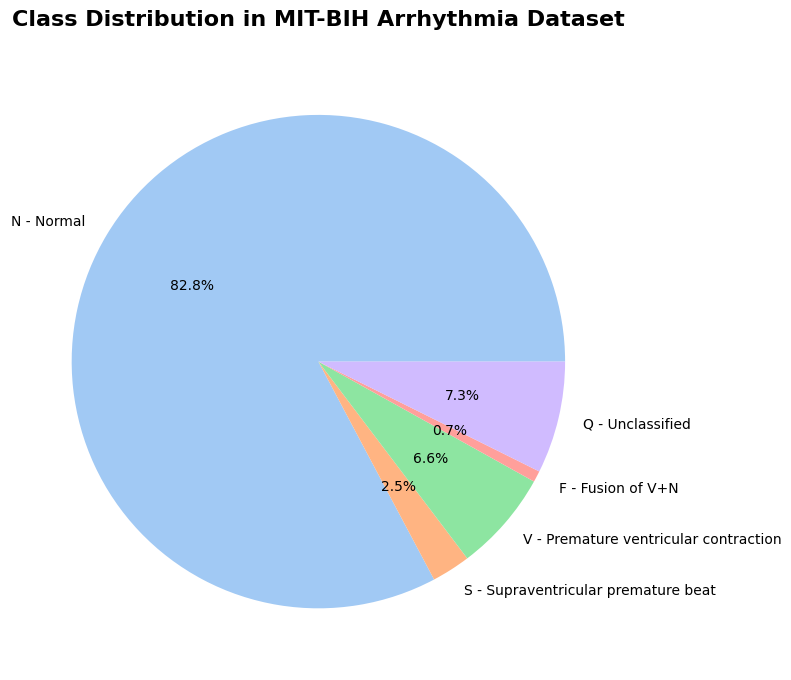

In [10]:

# Map class IDs -> short + description labels
labels = [
    f"{mitbih_labels_map[i]} - {mitbih_labels_to_desc[mitbih_labels_map[i]]}"
    for i in class_counts.index
]

# --- Colors ---
colors = sns.color_palette("pastel", len(class_counts))

# --- Plot setup ---
fig, ax = plt.subplots(figsize=(8, 8))

plt.pie(class_counts, labels=labels, colors=colors, autopct='%1.1f%%')

ax.set_title("Class Distribution in MIT-BIH Arrhythmia Dataset", fontsize=16, weight='bold', pad=20)

plt.tight_layout()

plt.show()

#### PTBDB

In [11]:
class_counts = ptbdb.iloc[:, -1].value_counts().sort_index()
expected = [class_counts.mean()] * len(class_counts)
imbalance_ratio = class_counts.min() / class_counts.max()

chi2, p_value = chisquare(class_counts, expected)

print(f"Chi-squared test statistic: {chi2:.4f}")
print(f"P-value: {p_value:.4f}")
print(f"Imbalance ratio: {imbalance_ratio:.4f}")

print(f"Class counts:\t{class_counts}") # pie chart

Chi-squared test statistic: 2864.6975
P-value: 0.0000
Imbalance ratio: 0.3852
Class counts:	187
0.0     4045
1.0    10500
Name: count, dtype: int64


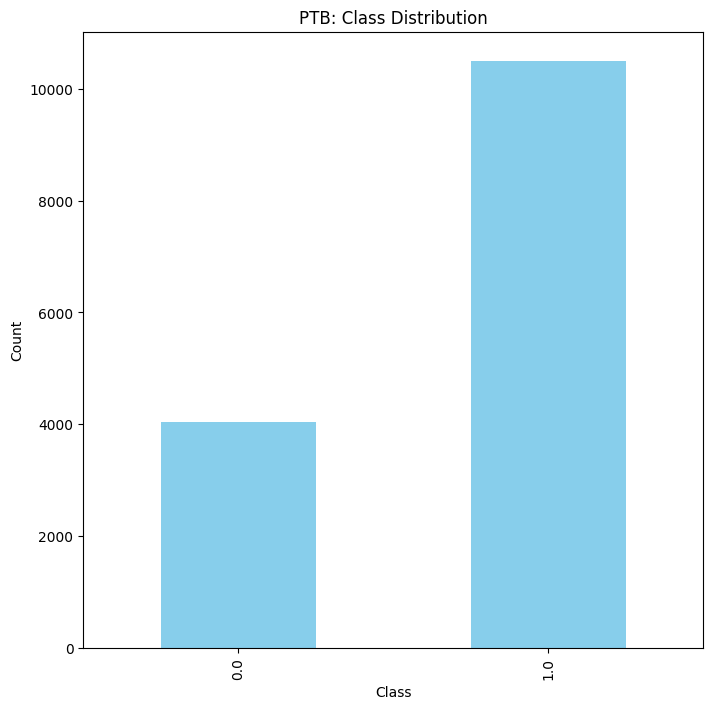

In [12]:
colors = sns.color_palette("pastel", len(class_counts))
fig, ax = plt.subplots(figsize=(8, 8))

class_counts = ptbdb[187].value_counts().sort_index()
class_counts.plot(kind='bar', color='skyblue')
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('PTB: Class Distribution')
plt.show()

## 5. Plots

### PTBDB: Normal vs Abnormal


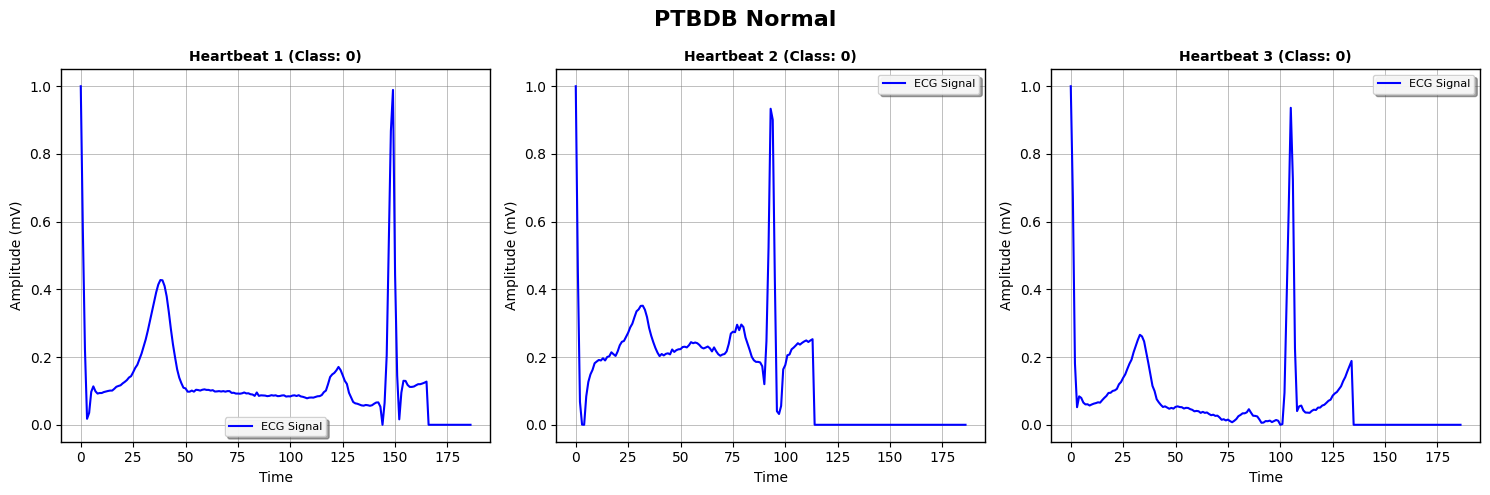

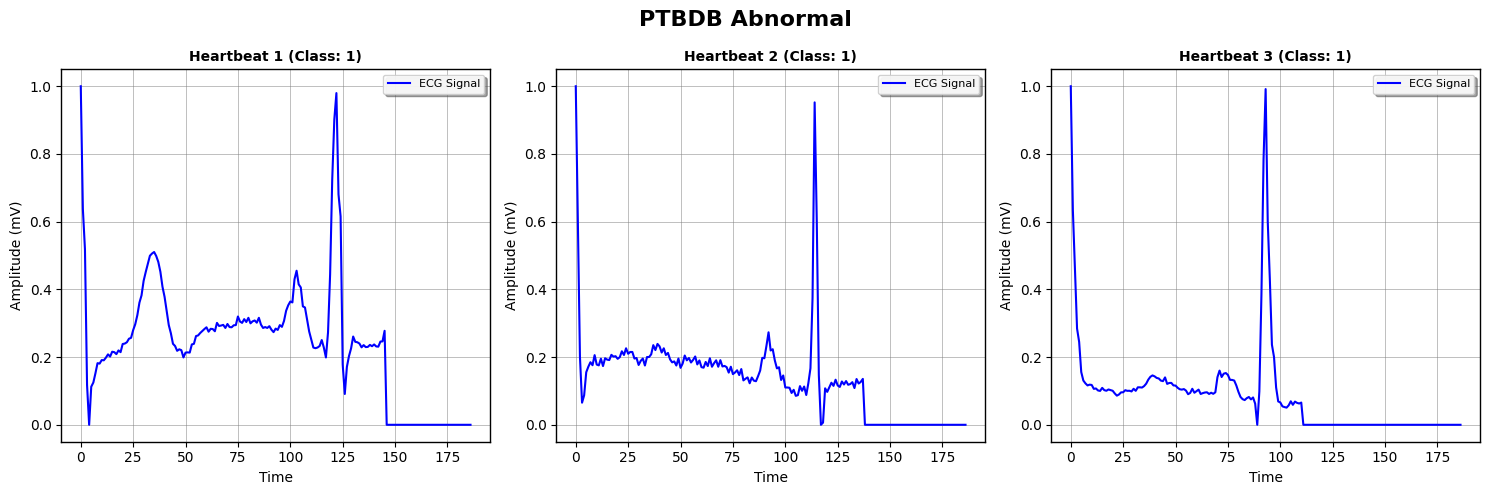

In [13]:
normal_heartbeat = ptbdb[ptbdb[187] == 0].sample(3)
abnormal_heartbeat = ptbdb[ptbdb[187] == 1].sample(3)
fig = plot_multiple_heartbeats(normal_heartbeat, title="PTBDB Normal")
fig = plot_multiple_heartbeats(abnormal_heartbeat, title="PTBDB Abnormal")

### MITBIH: Plots for all classes

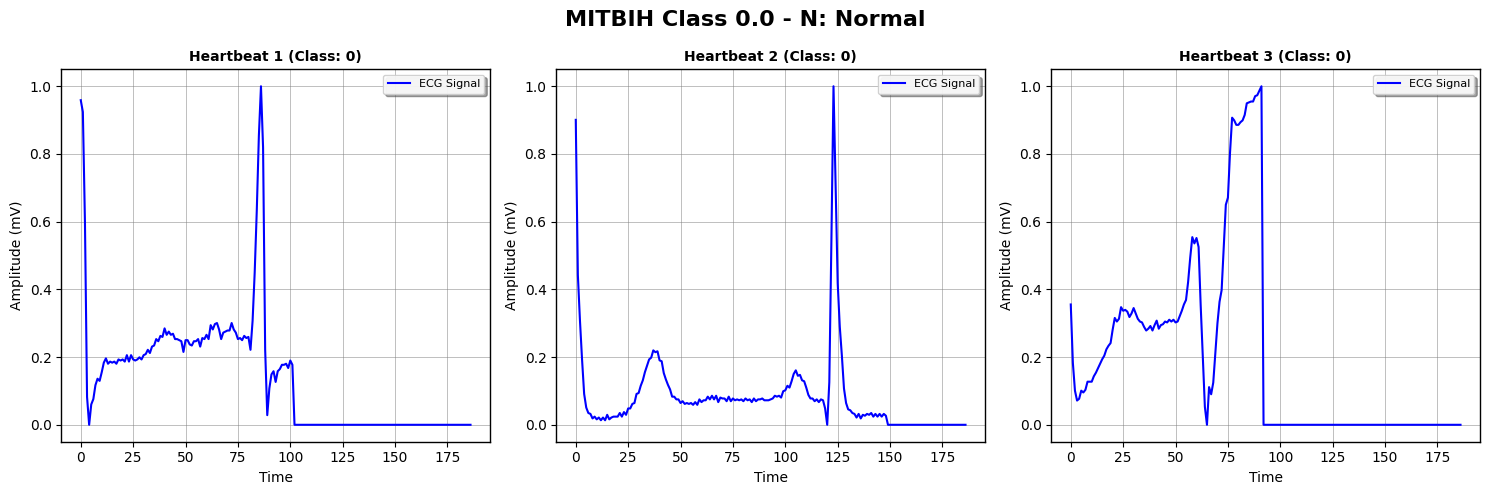

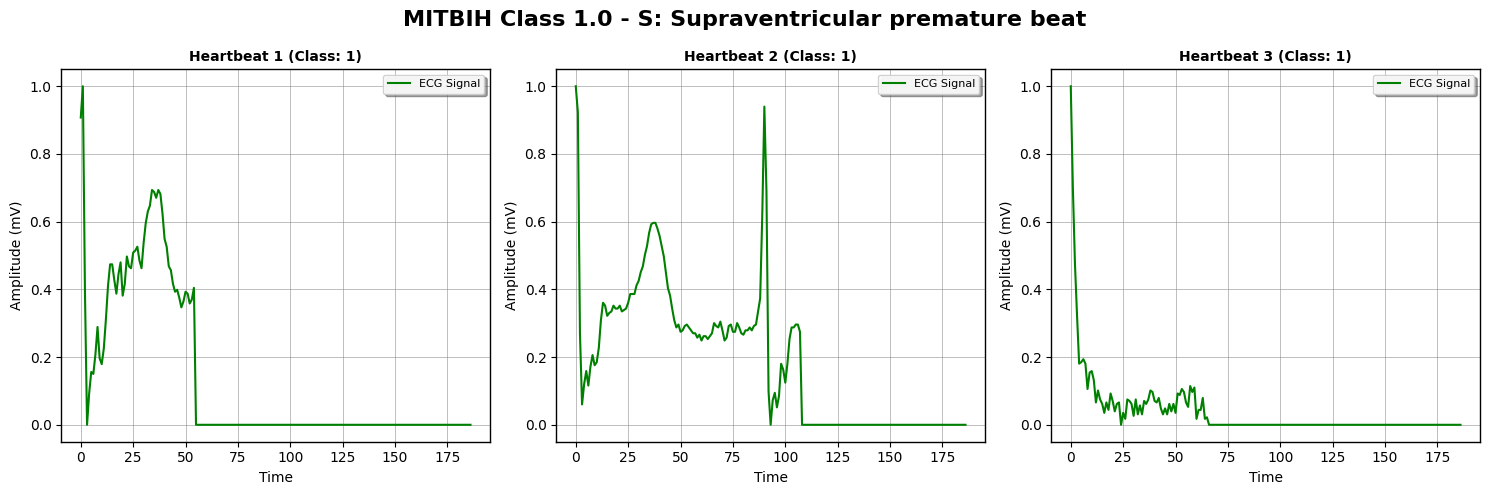

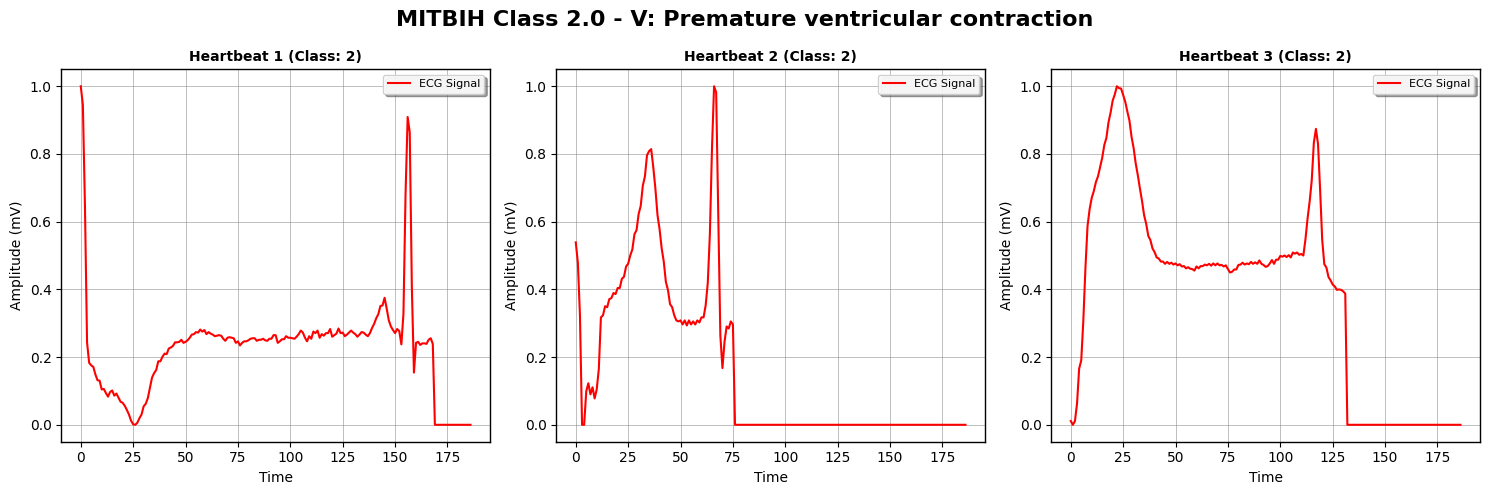

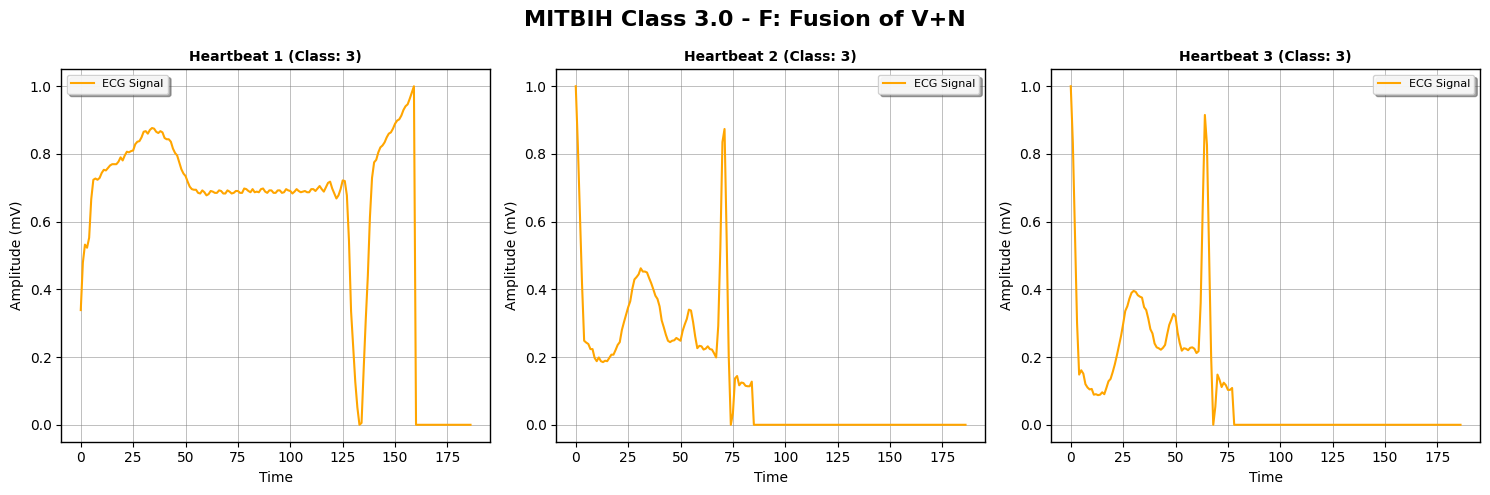

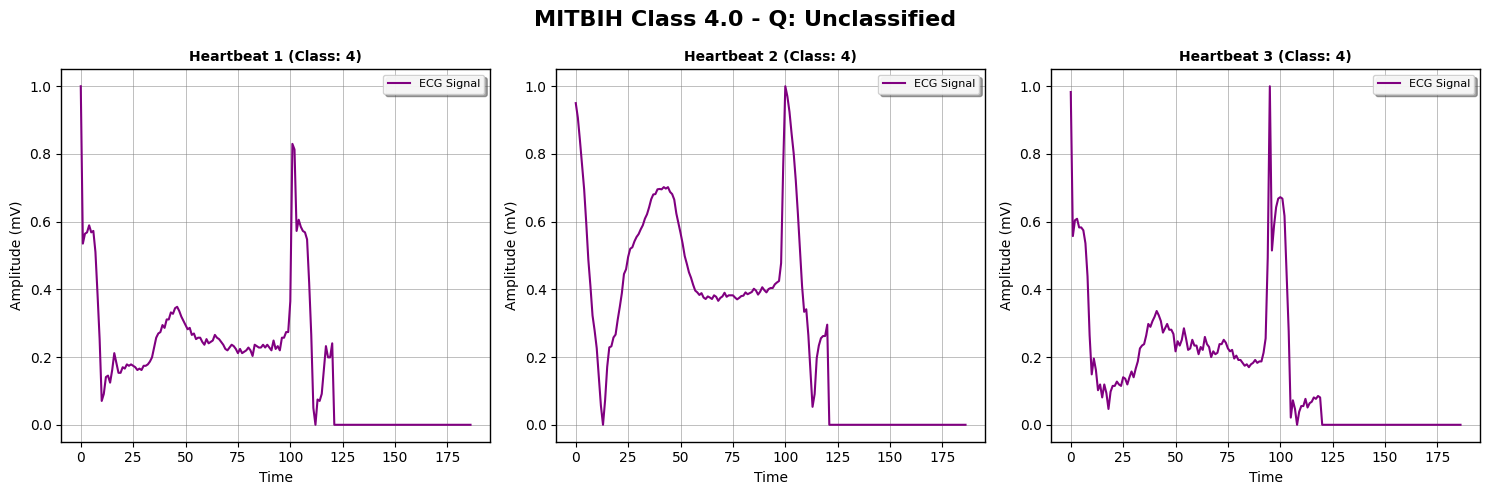

In [14]:
classes = mitbih[187].unique()
colors = ['blue', 'green', 'red', 'orange', 'purple', 'brown', 'pink', 'cyan', 'magenta', 'lime']

for i, _class in enumerate(classes):
    heartbeat = mitbih[mitbih[187] == _class].sample(3)
    title = f"MITBIH Class {_class} - {mitbih_labels_map[_class]}: {mitbih_labels_to_desc[mitbih_labels_map[_class]]}"
    fig = plot_multiple_heartbeats(heartbeat, title=title, color=colors[i])

## 6. Check classifications

Are the classifications correct or are there unusual data rows? 

Can be answered by looking at extrem R-R distances ( times between R peaks ).

Each row contains 1.2R ( heartbeats) - and is zero-padded to allow Deep Learning techniques to be applied.
Calculate R by:
- index of zero padding 
- dividing by 1.2

Thus:
- compare classes
- plot differences / outliers

In [15]:
def find_first_nonzero_index(arr):
    for i in range(len(arr) - 1, -1, -1):
        if arr[i] != 0:
            first_zero_index = ( i + 1 ) / 1.2
            break
        else:
            first_zero_index = 0  # all zeros
    return first_zero_index

### PTB

In [16]:
ptbdb_r = ptbdb.iloc[:, :-1].apply(lambda row: find_first_nonzero_index(row.values), axis=1)
result_ptbdb_r = pd.concat([ptbdb_r.rename('zero_pad_start'), ptbdb.iloc[:, -1].rename('target')], axis=1)

result_ptbdb_r.describe()

,zero_pad_start,target
count,14545.000000,14545.000000
mean,97.992495,0.721898
std,20.833264,0.448080
min,42.500000,0.000000
25%,83.333333,0.000000
50%,97.500000,1.000000
75%,112.500000,1.000000
max,155.000000,1.000000


In [17]:
result_ptbdb_r[result_ptbdb_r["target"] == 1].describe()

,zero_pad_start,target
count,10500.000000,10500.0
mean,93.869841,1.0
std,20.640430,0.0
min,42.500000,1.0
25%,80.833333,1.0
50%,91.666667,1.0
75%,106.666667,1.0
max,155.000000,1.0


In [18]:
result_ptbdb_r[result_ptbdb_r["target"] == 0].describe()

,zero_pad_start,target
count,4045.000000,4045.0
mean,108.694067,0.0
std,17.210860,0.0
min,51.666667,0.0
25%,97.500000,0.0
50%,108.333333,0.0
75%,120.833333,0.0
max,155.000000,0.0


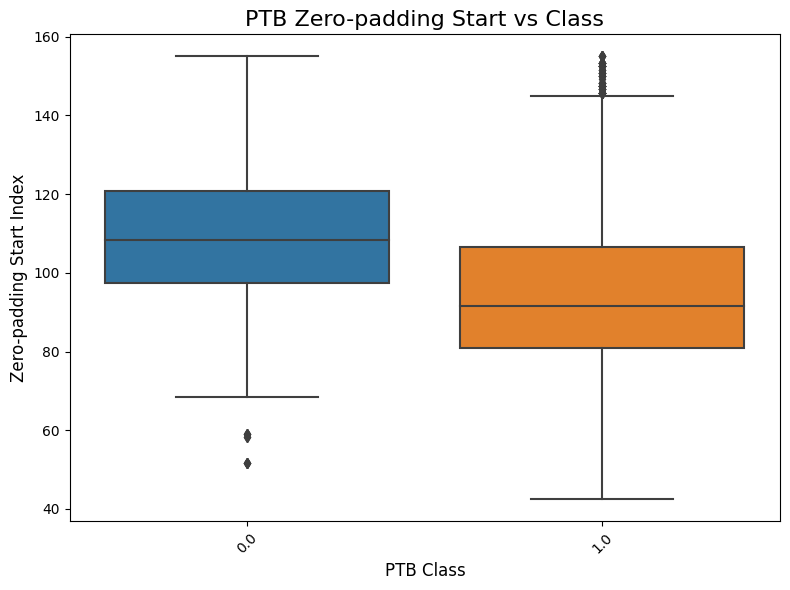

In [19]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='target', y='zero_pad_start', data=result_ptbdb_r)
plt.title('PTB Zero-padding Start vs Class', fontsize=16)
plt.xlabel('PTB Class', fontsize=12)
plt.ylabel('Zero-padding Start Index', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Extremes

In [20]:
# Function to get outlier indices for each class
def get_outliers_idx(df, value_col, class_col):
    outlier_indices = []
    
    for cls, group in df.groupby(class_col):
        q1 = group[value_col].quantile(0.25)
        q3 = group[value_col].quantile(0.75)
        iqr = q3 - q1
        lower_whisker = q1 - 1.5 * iqr
        upper_whisker = q3 + 1.5 * iqr
        
        # Identify outliers
        outliers = group[(group[value_col] < lower_whisker) | (group[value_col] > upper_whisker)]
        outlier_indices.extend(outliers.index.tolist())
    
    return outlier_indices

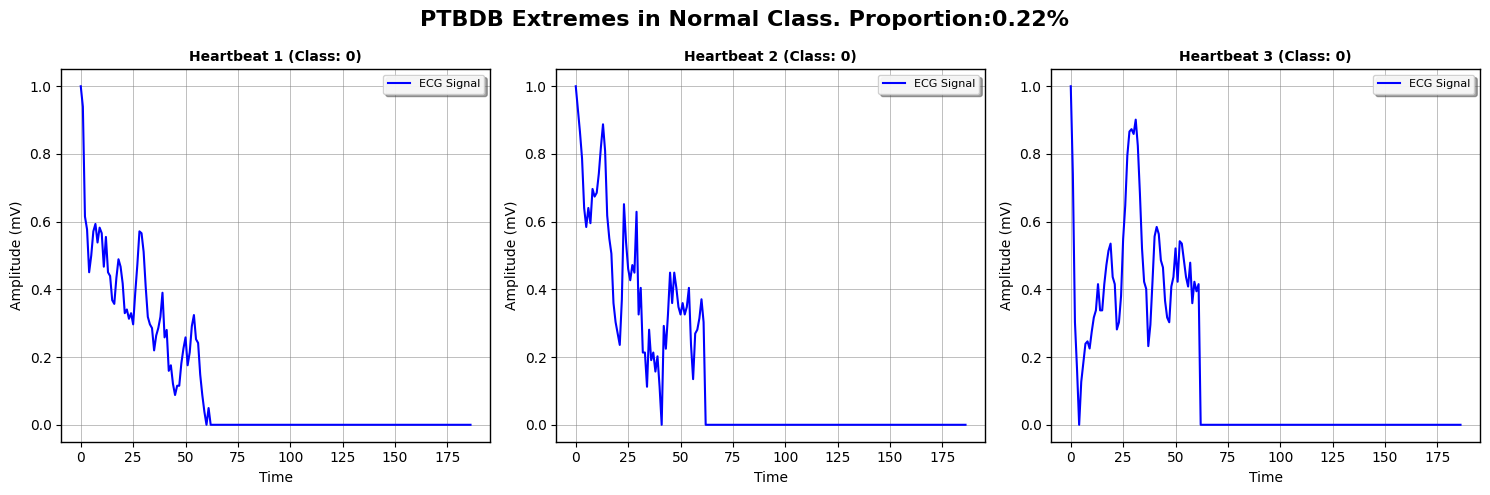

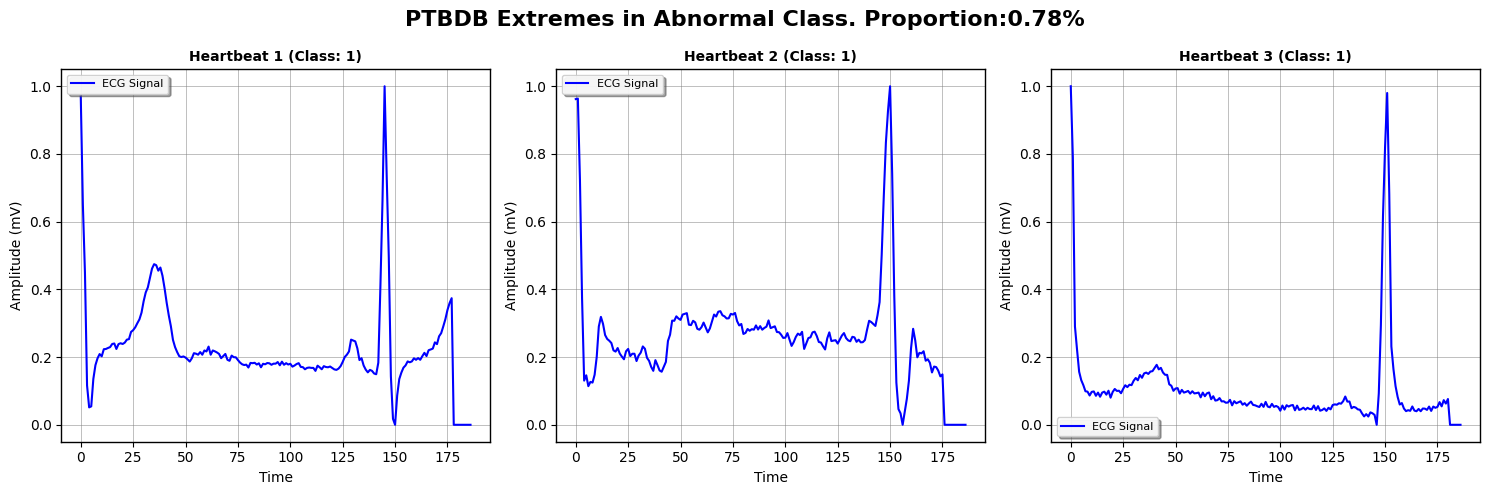

In [21]:
for c in [0,1]:
    df = result_ptbdb_r[result_ptbdb_r["target"] == c]
    idx = get_outliers_idx(df, 'zero_pad_start', 'target')
    
    proportion = len(idx) / len(df) * 100

    if c == 0:
        n = "Normal"
    if c == 1:
        n = "Abnormal"

    plot_multiple_heartbeats(ptbdb.iloc[idx].sample(3), title=f"PTBDB Extremes in {n} Class. Proportion:{proportion:.2f}%")

### MITBIH

In [22]:
mitbih_r = mitbih.iloc[:, :-1].apply(lambda row: find_first_nonzero_index(row.values), axis=1)
result_mitbih_r = pd.concat([mitbih_r.rename('zero_pad_start'), mitbih.iloc[:, -1].rename('target')], axis=1)

result_mitbih_r.describe()

result_mitbih_r.head()

,zero_pad_start,target
0,83.333333,0.0
1,114.166667,0.0
2,79.166667,0.0
3,80.000000,0.0
4,116.666667,0.0


In [23]:
for c in mitbih[187].unique():
    display(result_mitbih_r[result_mitbih_r["target"] == c].describe())

,zero_pad_start,target
count,90589.000000,90589.0
mean,92.299599,0.0
std,22.645083,0.0
min,8.333333,0.0
25%,77.500000,0.0
50%,88.333333,0.0
75%,105.833333,0.0
max,155.833333,0.0


,zero_pad_start,target
count,2779.000000,2779.0
mean,95.137639,1.0
std,32.549617,0.0
min,18.333333,1.0
25%,79.166667,1.0
50%,89.166667,1.0
75%,113.333333,1.0
max,155.833333,1.0


,zero_pad_start,target
count,7236.000000,7236.0
mean,98.246844,2.0
std,29.194083,0.0
min,11.666667,2.0
25%,79.166667,2.0
50%,95.000000,2.0
75%,117.500000,2.0
max,155.833333,2.0


,zero_pad_start,target
count,803.000000,803.0
mean,65.381901,3.0
std,11.472276,0.0
min,24.166667,3.0
25%,61.666667,3.0
50%,65.000000,3.0
75%,67.500000,3.0
max,155.833333,3.0


,zero_pad_start,target
count,8039.000000,8039.0
mean,98.608969,4.0
std,7.991169,0.0
min,25.833333,4.0
25%,96.666667,4.0
50%,100.000000,4.0
75%,102.500000,4.0
max,152.500000,4.0


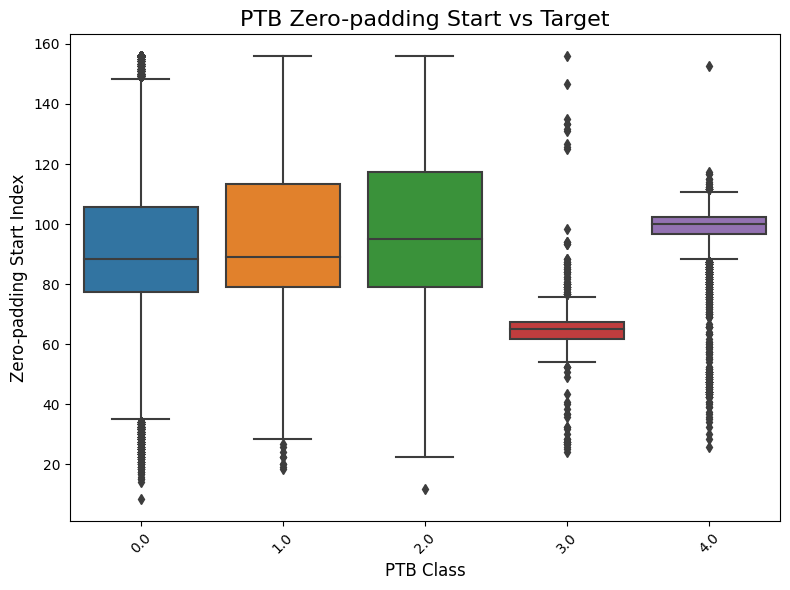

In [24]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='target', y='zero_pad_start', data=result_mitbih_r)
plt.title('PTB Zero-padding Start vs Target', fontsize=16)
plt.xlabel('PTB Class', fontsize=12)
plt.ylabel('Zero-padding Start Index', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

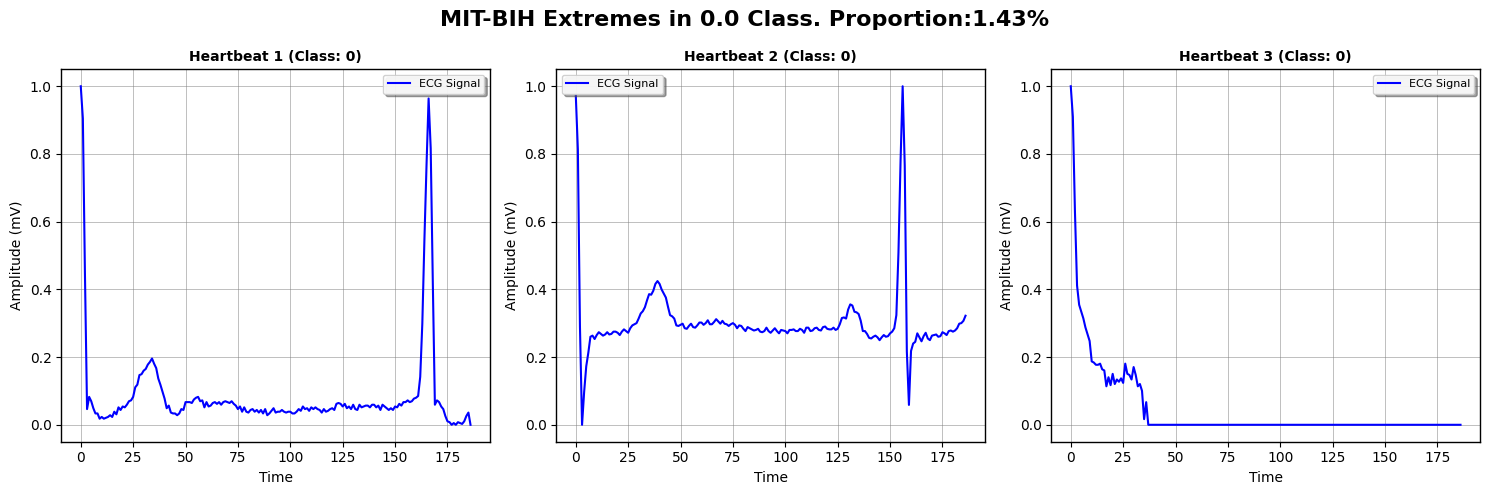

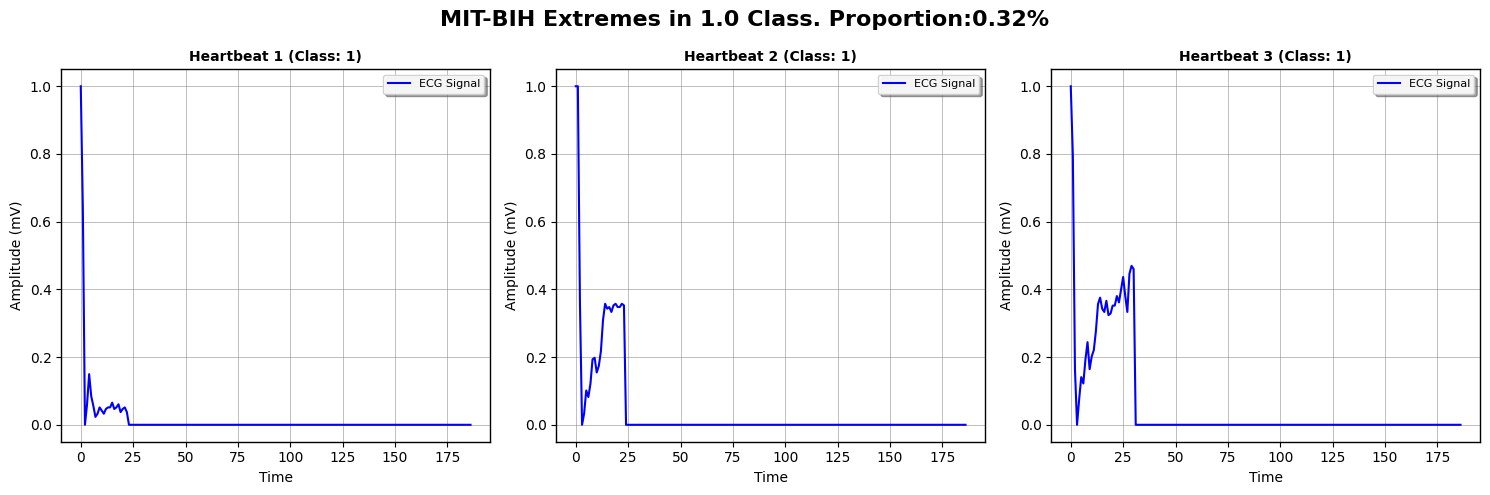

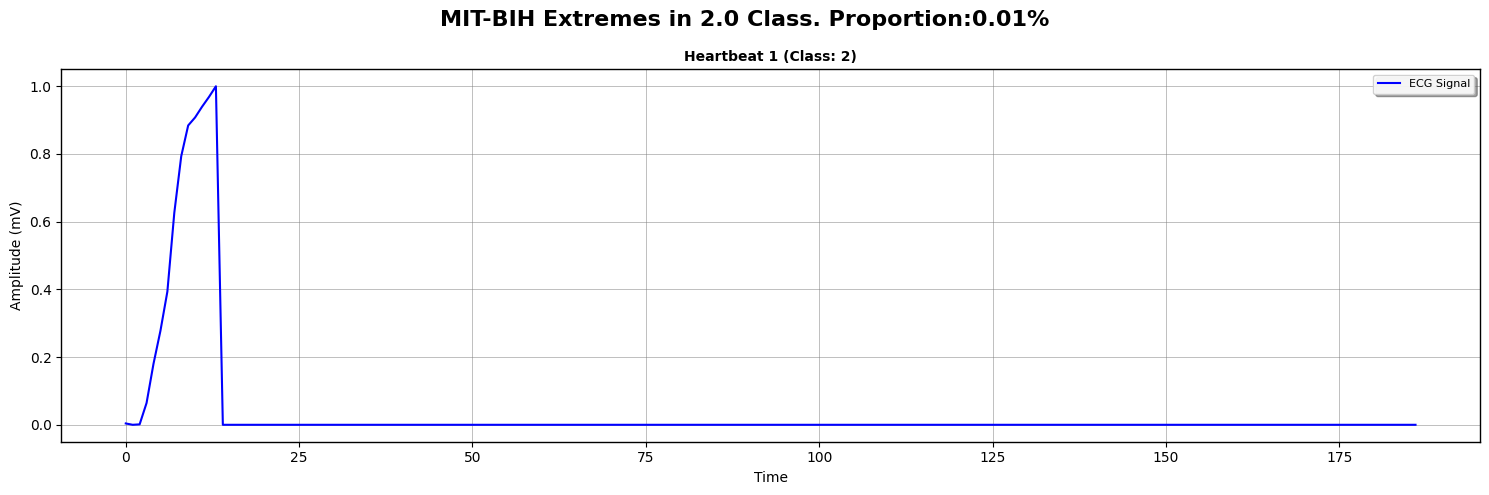

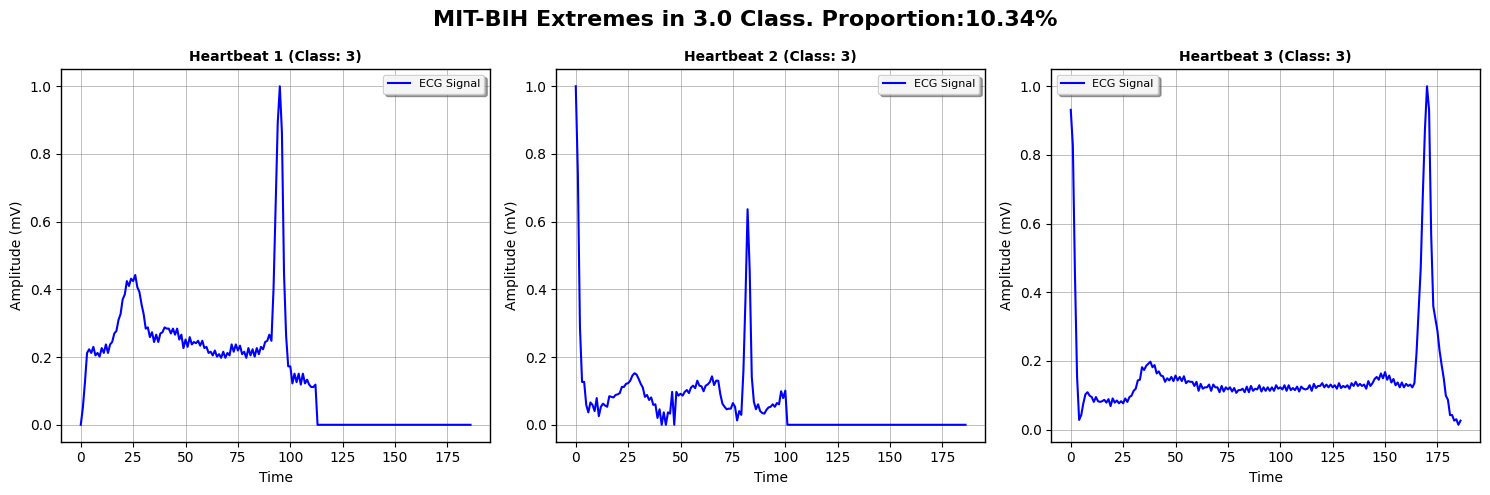

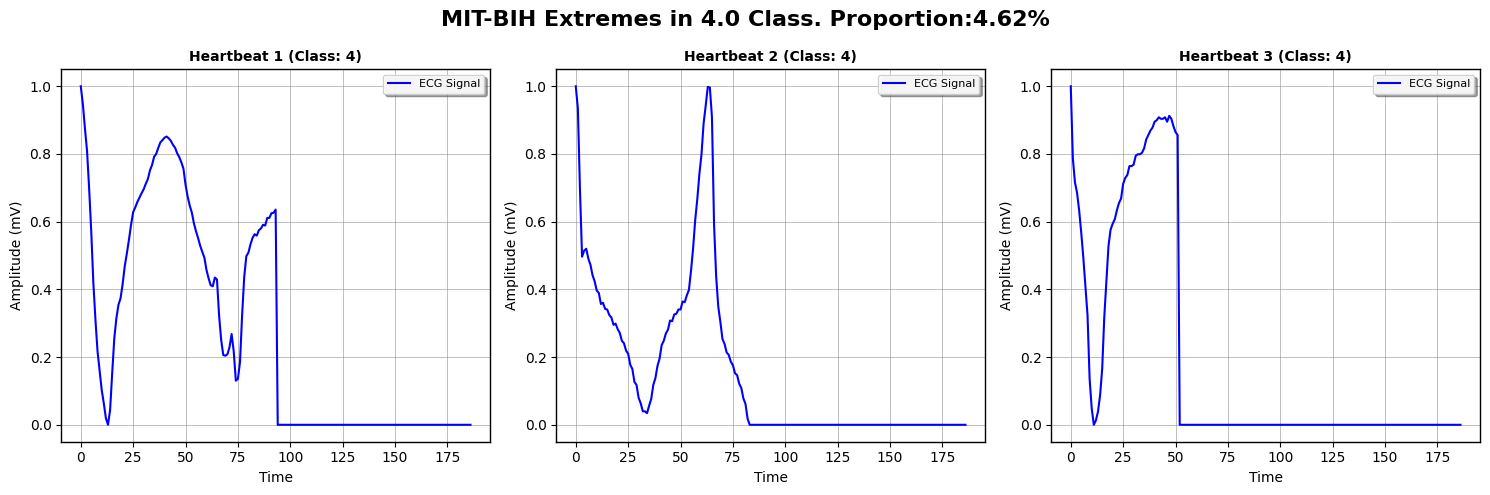

In [25]:
for c in mitbih[187].unique():
    df = result_mitbih_r[result_mitbih_r["target"] == c]
    idx = get_outliers_idx(df, 'zero_pad_start', 'target')
    
    proportion = len(idx) / len(df) * 100

    sample = mitbih.iloc[idx]
    
    if len(sample) > 0:
        min_len = min([len(sample), 3])
        plot_multiple_heartbeats(sample.sample(min_len), title=f"MIT-BIH Extremes in {str(c)} Class. Proportion:{proportion:.2f}%")

### Is data between classes significantly different?

#### Kruskal Wallis Test on Targets + Rs

Kruskal-Wallis is univariate, so it tests differences along a single variable at a time --> multivariate approach needed

1. use PCA
2. run kruskal wallis on each principal component

In [26]:
from sklearn.decomposition import PCA
from scipy.stats import kruskal
import pandas as pd

def kruskal_multivariate(df, target_col=None, n_components=5):
    if target_col is None:
        target_col = df.columns[-1]

    X = df.drop(columns=target_col)
    y = df[target_col]

    p_values = []
    # Reduce to n_components using PCA
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)

    for i in range(n_components):
        groups = [X_pca[y == cls, i] for cls in pd.unique(y)]
        stat, p = kruskal(*groups)
        p_values.append(p)

    return pd.DataFrame({
        'PC': [f'PC{i+1}' for i in range(n_components)],
        'p_value': p_values
    })

In [27]:
kruskal_results_mit = kruskal_multivariate(mitbih, target_col=187, n_components=5)
print(kruskal_results_mit)

    PC        p_value
0  PC1   0.000000e+00
1  PC2  4.628395e-123
2  PC3   0.000000e+00
3  PC4   0.000000e+00
4  PC5   0.000000e+00


In [28]:
kruskal_results_ptb = kruskal_multivariate(ptbdb, target_col=187, n_components=2)
print(kruskal_results_ptb)

    PC        p_value
0  PC1   2.546811e-64
1  PC2  8.214243e-228


--> low p-vals -> significantly different along principal component

#### Pairwise comparison of R

In [29]:
from itertools import combinations 

def kruskal_class_pairs(df, target_col=None, agg_func='mean'):
    if target_col is None:
        target_col = df.columns[-1]

    X = df.drop(columns=target_col)
    y = df[target_col]

    # Aggregate features into a single value per sample
    if agg_func == 'mean':
        X_agg = X.mean(axis=1)
    elif agg_func == 'sum':
        X_agg = X.sum(axis=1)
    else:
        raise ValueError("agg_func must be 'mean' or 'sum'")

    results = []

    classes = pd.unique(y)
    for class1, class2 in combinations(classes, 2):
        group1 = X_agg[y == class1]
        group2 = X_agg[y == class2]

        stat, p = kruskal(group1, group2)
        results.append({
            'class1': class1,
            'class2': class2,
            'p_value': p
        })

    return pd.DataFrame(results).sort_values('p_value')


In [30]:
mitbih_r_copy = result_mitbih_r.copy()
result_ptbdb_r_copy = result_ptbdb_r.copy()

mitbih_r_copy['target'] = 'MIT_' + mitbih_r_copy['target'].astype(str)
result_ptbdb_r_copy['target'] = 'PTB_' + result_ptbdb_r_copy['target'].astype(str)

combined_df = pd.concat([mitbih_r_copy, result_ptbdb_r_copy], ignore_index=True)

combined_df.head()


,zero_pad_start,target
0,83.333333,MIT_0.0
1,114.166667,MIT_0.0
2,79.166667,MIT_0.0
3,80.000000,MIT_0.0
4,116.666667,MIT_0.0


In [31]:
kruskal_pairwise_df = kruskal_class_pairs(combined_df, target_col='target', agg_func='mean')

In [32]:
kruskal_pairwise_df[kruskal_pairwise_df["p_value"] > 0.01]

,class1,class2,p_value
9,MIT_1.0,PTB_1.0,0.590347


In [33]:
kruskal_pairwise_df.sort_values(by='class1', ascending=True)

,class1,class2,p_value
3,MIT_0.0,MIT_4.0,0.000000e+00
5,MIT_0.0,PTB_0.0,0.000000e+00
4,MIT_0.0,PTB_1.0,3.933720e-30
1,MIT_0.0,MIT_2.0,1.948410e-67
2,MIT_0.0,MIT_3.0,3.164628e-309
0,MIT_0.0,MIT_1.0,1.348408e-06
7,MIT_1.0,MIT_3.0,1.092146e-146
6,MIT_1.0,MIT_2.0,4.915174e-07
8,MIT_1.0,MIT_4.0,7.482243e-86
10,MIT_1.0,PTB_0.0,1.150519e-130


## Results / Anomalies
 
### PTB

1. Last column in PTBDB is always empty, probably added to make comparison possible ( don't delete )
2. Imbalanced classes validated through CHI2 -> resampling needed
3. For extreme values in R-R distances: check classifications / decision needed. But count is low (0.2%)

### MITBIH

1. Large imbalance in MITBIH dataset validated through CHI2 -> resampling needed
2. For extreme values in R-R distances: check classifications / decision needed. Count for class 3 and 4 are relatively high.
3. MIT class 1 vs PTB class 1 might define the same abnormal heart beats

## Generate Audit Report

In [34]:
# Generate audit reports for all CSV files (specify the correct path)
generate_data_audit_report(data_dir="../data/original/", output_dir="../reports/DataAudit/")

# Generate summary report (specify the correct path)
generate_summary_report(data_dir="../data/original/", output_file="../reports/DataAudit/data_summary.txt")

Found 4 CSV files to audit:
  - ptbdb_normal.csv
  - mitbih_train.csv
  - ptbdb_abnormal.csv
  - mitbih_test.csv

Processing ptbdb_normal.csv...
  Saved: ../reports/DataAudit/data_audit_ptbdb_normal.csv
✓ Audit report generated for ptbdb_normal.csv

Processing mitbih_train.csv...
  Saved: ../reports/DataAudit/data_audit_mitbih_train.csv
✓ Audit report generated for mitbih_train.csv

Processing ptbdb_abnormal.csv...
  Saved: ../reports/DataAudit/data_audit_ptbdb_abnormal.csv
✓ Audit report generated for ptbdb_abnormal.csv

Processing mitbih_test.csv...
  Saved: ../reports/DataAudit/data_audit_mitbih_test.csv
✓ Audit report generated for mitbih_test.csv

Data audit reports completed! Check ../reports/DataAudit/ for results.
Summary report saved to: ../reports/DataAudit/data_summary.txt
